In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform


## Import data

In [47]:
data_df= pd.read_csv("../raw_data/churn_df_underbalanced.csv")

In [48]:
data_df = data_df.sample(frac=1, random_state=42)

In [49]:
data_df = data_df.drop(['Unnamed: 0','msno', 'bd'], axis=1)

In [55]:
scale_features = ['payment_plan_days',
                  'plan_list_price',
                  'actual_amount_paid',
                  'remaining_plan_duration',
                  'num_25',
                  'num_50',
                  'num_75',
                  'num_985',
                  'num_100',
                  'num_unq',
                  'total_secs',
                  'usage_from_ltd',
                  'registration_year',
                  'expire_year',
                  'last_transaction_year',
                  'payment_method_id', 'city', 'registered_via'
                 ]

## Pipeline

In [57]:
# Build the pipeline with the different steps
num_pipeline = make_pipeline(SimpleImputer(strategy="mean"),StandardScaler())

preprocessor = ColumnTransformer([
    ('num_transformer', num_pipeline, scale_features)],
    remainder='passthrough'
)


In [52]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_transformer',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['payment_plan_days', 'plan_list_price',
                                  'actual_amount_paid',
                                  'remaining_plan_duration', 'num_25', 'num_50',
                                  'num_75', 'num_985', 'num_100', 'num_unq',
                                  'total_secs', 'usage_from_ltd',
                                  'registration_year', 'expire_year',
                                  'last_transaction_yearpayment_method_id',
                                  'city', 'registered_via'])])

In [53]:
#create X and y
X = data_df.drop(['is_churn'], axis=1)
y= data_df['is_churn']

In [58]:
# Use fit on X_train and then transform both datasets
preprocessor.fit(X)
X_train_transformed = preprocessor.transform(X)

In [59]:
# Convert transformed data back to DataFrame to ensure column order is maintained
X_train_transformed = pd.DataFrame(
    X_train_transformed, 
    columns=preprocessor.get_feature_names_out()
)

## Logistic Regresssion model

In [60]:
model = LogisticRegression(C=4.82, solver= 'liblinear', max_iter= 11, penalty= 'l2')

cv_results = cross_validate(model, X_train_transformed, y, cv=5, scoring='precision')

precision = cv_results['test_score'].mean()

/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarnin

In [115]:
param_distributions

{'C': [4.82], 'solver': ['liblinear'], 'max_iter': [11], 'penalty': ['l2']}

In [44]:
cv_results

{'fit_time': array([0.12899494, 0.16121292, 0.16274214, 0.14197922, 0.16290021]),
 'score_time': array([0.0108912 , 0.00378394, 0.00984287, 0.00365901, 0.00931382]),
 'test_score': array([0.90954774, 0.91538662, 0.91974684, 0.895659  , 0.91430515])}

In [61]:
precision

0.9217280618597042

## Learning curves for all features

/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarnin

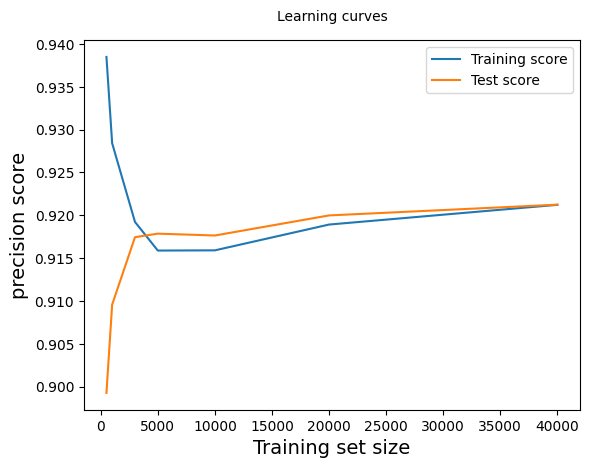

In [62]:
#learning curves for all features

train_sizes = [100, 500, 1000, 3000, 5000, 10000, 20000, 40000]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, 
    X=X_train_transformed, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    scoring='precision'  # Set scoring to precision
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('precision score', fontsize=14)  # Change the ylabel to precision score
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
plt.legend()

## Learning curves for 15 features

In [122]:
#feature importance top 15
model.fit(X_train_transformed, y)
coefficients = model.coef_[0]
top_15_features = np.argsort(np.abs(coefficients))[-15:][::-1]
feature_names = X_train_transformed.columns
top_15_features = feature_names[top_15_features].tolist()
top_15_features

/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['num_transformer__remaining_plan_duration',
 'remainder__is_cancel',
 'num_transformer__expire_year',
 'remainder__discount_percentage',
 'remainder__last_transaction_month_sin',
 'remainder__expire_month_cos',
 'num_transformer__plan_list_price',
 'remainder__last_transaction_month_cos',
 'remainder__expire_month_sin',
 'remainder__is_auto_renew',
 'num_transformer__payment_plan_days',
 'num_transformer__actual_amount_paid',
 'remainder__period_-5_churn',
 'remainder__period_0_churn',
 'remainder__period_-3_churn']

In [123]:
#take only top 15 features
X_train_transformed_top_15 = X_train_transformed[top_15_features]


/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarnin

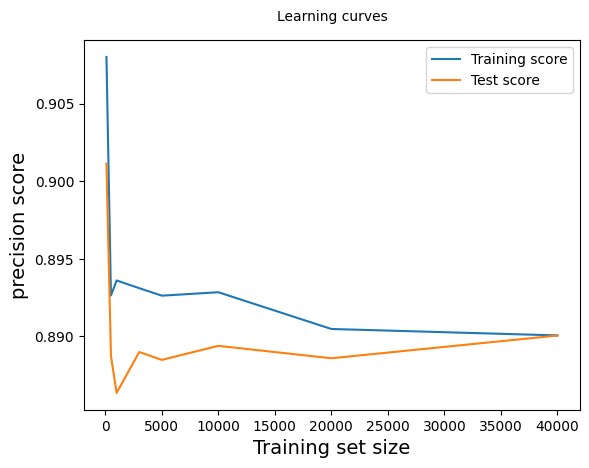

In [124]:
#learning curves for top 15 features

train_sizes = [100, 500, 1000, 3000, 5000, 10000, 20000, 40000]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, 
    X=X_train_transformed_top_15, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    shuffle=True,
    scoring='precision'  # Set scoring to precision
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('precision score', fontsize=14)  # Change the ylabel to precision score
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
plt.legend()

## Learning curves for 8 features

In [72]:
#feature importance top 8
model.fit(X_train_transformed, y)
coefficients = model.coef_[0]
top_8_features = np.argsort(np.abs(coefficients))[-8:][::-1]
feature_names = X_train_transformed.columns
top_8_features = feature_names[top_8_features].tolist()
top_8_features


['num_transformer__remaining_plan_duration',
 'remainder__is_cancel',
 'num_transformer__expire_year',
 'remainder__expire_month_cos',
 'remainder__discount_percentage',
 'remainder__expire_month_sin',
 'num_transformer__plan_list_price',
 'remainder__is_auto_renew']

In [73]:
#take only top 8 features
X_train_transformed_top_8 = X_train_transformed[top_8_features]

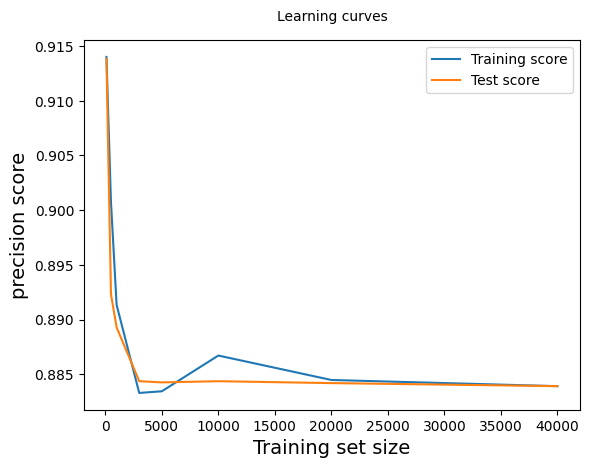

In [74]:
#learning curves with top 8 features

train_sizes = [100, 500, 1000, 3000, 5000, 10000, 20000, 40000]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, 
    X=X_train_transformed_top_8, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    shuffle=True,
    scoring='precision'  # Set scoring to precision
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('precision score', fontsize=14)  # Change the ylabel to precision score
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
plt.legend()

## Random Search

In [48]:
#random search

param_distributions = {
    'C': uniform(loc=0, scale=4), 
    'solver': ['lbfgs', 'saga', 'newton-cg', ], 
    'penalty': ['l1', 'l2'],
    'max_iter': [1, 10, 50, 100, 500, 1000, 3000, 10000]
}

In [50]:
# Initialize the model
model = LogisticRegression()

# Initialize Random Search
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_distributions,
    n_iter=100,  
    cv=5,      
    scoring='precision',  
    n_jobs=-1,  
    random_state=42,
    verbose=0 
)

# Fit data
random_search.fit(X_train_transformed, y)

/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/linear_model

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1571a6140>,
                                        'max_iter': [1, 10, 50, 100, 500, 1000,
                                                     3000, 10000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['lbfgs', 'saga',
                                                   'newton-cg']},
                   random_state=42, scoring='precision')

In [51]:
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'C': 3.42529716751237, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


## Grid Search

In [112]:
param_distributions = {
    'C': [4.82],
    'solver': ['liblinear'], 
    'max_iter': [11],
    'penalty': ['l2'],
}

In [110]:
# Initialize the model
logreg = LogisticRegression()

# Initialize Grid Search
grid_search = GridSearchCV(
    logreg, 
    param_grid=param_distributions,
    cv=5,        
    scoring='precision',  
    n_jobs=-1,   
    verbose=0 
)

# Fit data
grid_search.fit(X_train_transformed, y)

/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarnin

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [4.82],
                         'max_iter': [9, 10, 11, 12, 13, 15, 16, 20, 50, 100],
                         'penalty': ['l2'], 'solver': ['liblinear']},
             scoring='precision')

In [111]:
best_params_grid = grid_search.best_params_
best_model_grid = grid_search.best_estimator_

print("Best Parameters from Grid Search:", best_params_grid)

Best Parameters from Grid Search: {'C': 4.82, 'max_iter': 11, 'penalty': 'l2', 'solver': 'liblinear'}
